In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta
import numpy as np
import os 
#getting data 

don_df = pd.read_csv('ETFS/don.us.csv')
lst_days = [30, 60, 90, 120]
start_day = 2000

def prep_df(df):
    df.columns = df.columns.str.lower()
    df.index = pd.to_datetime(df.date)
    return df

def get_start_date(df, start_day):
    day1 = datetime.datetime.strptime(df.date[0], '%Y-%m-%d')
    start_date = day1 + timedelta(days=start_day)
    return start_date

def get_end_date(initial_date, num_days):
    end_date = initial_date + timedelta(days=num_days)
    return end_date
        
don_all_days = prep_df(don_df)

start_date = get_start_date(don_all_days, start_day)

end_day = len(don_all_days)

end_dates_lst = [(get_end_date(start_date, i)) for i in lst_days]


def get_close_prices(start_day, end_day, df):
    return df.close.iloc[start_day: start_day + end_day]
                         

def get_close_prices_multiple(start_day, days, df):
    df_dict = {}
    for i in days:
        df_dict[i] = get_close_prices(start_day, i, df)
    return df_dict

don_close_all = get_close_prices(0, end_day, don_all_days)

don_close_dict = get_close_prices_multiple(start_day, lst_days, don_all_days)

In [15]:
#Time series model first (ARIMA)
#make data stationary (further exploration of this in DONtimeseriesanalysis)
def log_transform(df):
    return np.log(df)
def difference(df):
    return (df- df.shift()).dropna()

def diff_and_log_transform(df):
    log_df = np.log(df)
    diff_log_df = (log_df - log_df.shift()).dropna()
    return diff_log_df

def diff_and_log_transform_multi(dict_in):
    df_dict = {}
    for i in dict_in:
        df_dict[i] = difference(log_transform(dict_in[i]))   
    return df_dict

transformed_don_all_days_close = diff_and_log_transform(don_close_all)

transformed_dict_don = diff_and_log_transform_multi(don_close_dict)


MA parameter all days
0
MA parameter 30 days
2
MA parameter 60 days
2
MA parameter 90 days
4
MA parameter 120 days
0


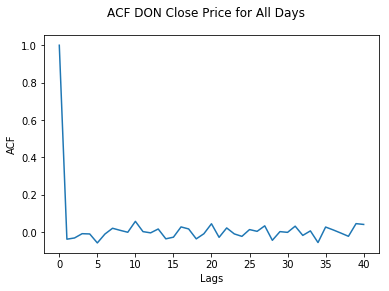

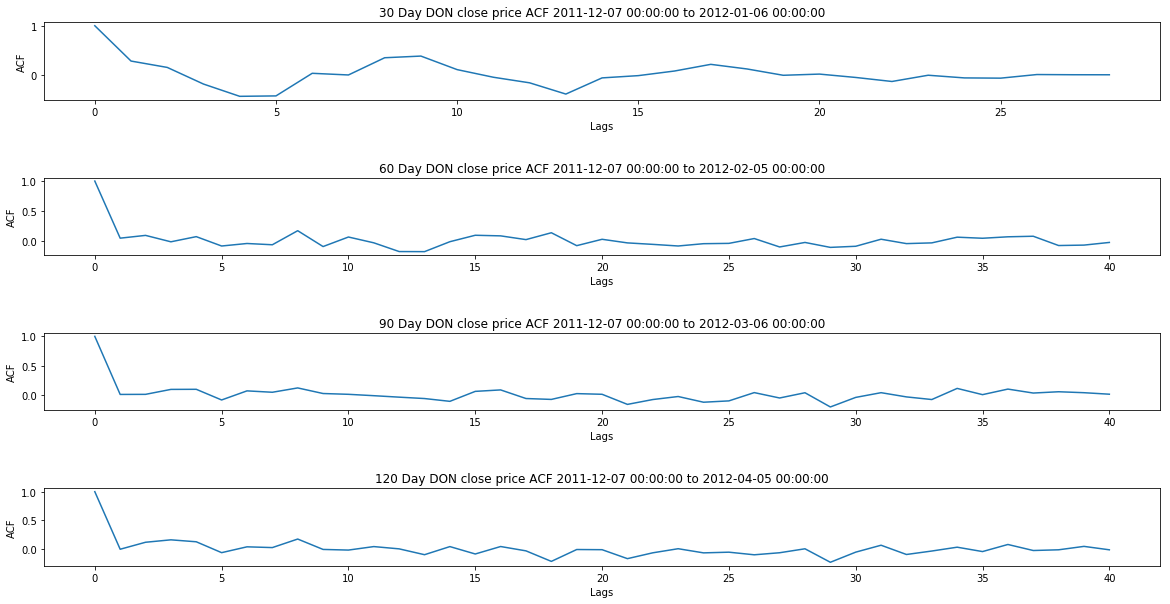

In [35]:
#Use ACF and PACF tests to determine parameters for ARIMA model 
from statsmodels.tsa.stattools import acf
from pandas.tools.plotting import autocorrelation_plot

def acf_multi(dict_in):
    df_dict = {}
    for i in dict_in:
        df_dict[i] = acf(dict_in[i])
    return df_dict

acf_don_all_days = acf(transformed_don_all_days_close)

acf_dict_don = acf_multi(transformed_dict_don)

thirty_day_acf, sixty_day_acf = acf_dict_don[30], acf_dict_don[60]
ninety_day_acf, hundred_twenty_day_acf = acf_dict_don[90], acf_dict_don[120]


plt.plot(acf_don_all_days)
plt.ylabel('ACF')
plt.xlabel('Lags')
plt.suptitle('ACF DON Close Price for All Days')


fig, axes = plt.subplots(4, gridspec_kw={'hspace': 1, 'wspace': 1}, figsize=(20,10))
for ax in axes.flat:
    ax.set(xlabel='Lags', ylabel='ACF')
    
# #compute MA value for arima 
    
axes[0].plot(thirty_day_acf)
axes[0].set_title('30 Day DON close price ACF '+ str(start_date) + ' to ' + str(end_dates_lst[0]))

axes[1].plot(sixty_day_acf)
axes[1].set_title('60 Day DON close price ACF '+ str(start_date) + ' to ' + str(end_dates_lst[1]))

axes[2].plot(ninety_day_acf)
axes[2].set_title('90 Day DON close price ACF '+ str(start_date) + ' to ' + str(end_dates_lst[2]))


axes[3].plot(hundred_twenty_day_acf)
axes[3].set_title('120 Day DON close price ACF '+ str(start_date) + ' to ' + str(end_dates_lst[3]))


def find_ma_prm(df_acf):
    value = 0
    for i in range(0, len(df_acf)):
        if df_acf[i] < 0.00001:
            return i - 1
        
def find_ma_prm_dict(dict_in):
    df_dict = {}
    for i in dict_in:
        df_dict[i] = find_ma_prm(dict_in[i])
    return df_dict

ma_prm_don_all_days = find_ma_prm(acf_don_all_days)

ma_prm_don_dict = find_ma_prm_dict(acf_dict_don)

print("MA parameter all days")
print(ma_prm_don_all_days)

print("MA parameter 30 days")
print(ma_prm_don_dict[30])

print("MA parameter 60 days")
print(ma_prm_don_dict[60])

print("MA parameter 90 days")
print(ma_prm_don_dict[90])

print("MA parameter 120 days")
print(ma_prm_don_dict[120])

AR parameter all days
0
AR parameter 30 days
2
AR parameter 60 days
2
AR parameter 90 days
4
AR parameter 120 days
0


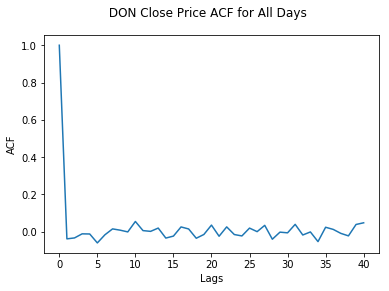

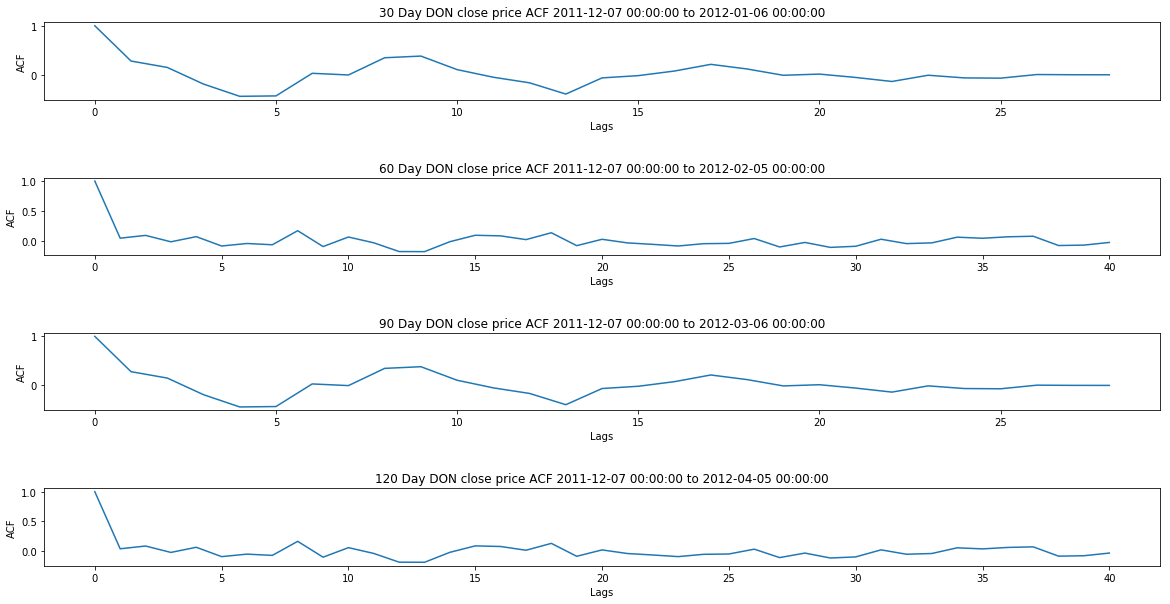

In [36]:
from statsmodels.tsa.stattools import pacf

def pacf_multi(dict_in):
    df_dict = {}
    for i in dict_in:
        df_dict[i] = acf(dict_in[i])
    return df_dict

pacf_don_all_days = pacf(transformed_don_all_days_close)

pacf_dict_don = pacf_multi(transformed_dict_don)

thirty_day_pacf, sixty_day_pacf = pacf_dict_don[30], pacf_dict_don[60]
ninety_day_pacf, hundred_twenty_day_pacf = pacf_dict_don[30], pacf_dict_don[60]


plt.plot(pacf_don_all_days)
plt.ylabel('ACF')
plt.xlabel('Lags')
plt.suptitle(' DON Close Price ACF for All Days')


fig, axes = plt.subplots(4, gridspec_kw={'hspace': 1, 'wspace': 1}, figsize=(20,10))
for ax in axes.flat:
    ax.set(xlabel='Lags', ylabel='ACF')
    
# #compute AR value for arima 
    
axes[0].plot(thirty_day_pacf)
axes[0].set_title('30 Day DON close price ACF '+ str(start_date) + ' to ' + str(end_dates_lst[0]))

axes[1].plot(sixty_day_pacf)
axes[1].set_title('60 Day DON close price ACF '+ str(start_date) + ' to ' + str(end_dates_lst[1]))

axes[2].plot(ninety_day_pacf)
axes[2].set_title('90 Day DON close price ACF '+ str(start_date) + ' to ' + str(end_dates_lst[2]))


axes[3].plot(hundred_twenty_day_pacf)
axes[3].set_title('120 Day DON close price ACF '+ str(start_date) + ' to ' + str(end_dates_lst[3]))



def find_ar_prm(df_pacf):
    value = 0
    for i in range(0, len(df_pacf)):
        if df_pacf[i] < 0.00001:
            return i - 1
        
def find_ar_prm_dict(dict_in):
    df_dict = {}
    for i in dict_in:
        df_dict[i] = find_ar_prm(dict_in[i])
    return df_dict

ar_prm_don_all_days = find_ar_prm(pacf_don_all_days)

ar_prm_don_dict = find_ar_prm_dict(pacf_dict_don)

print("AR parameter all days")
print(ar_prm_don_all_days)

print("AR parameter 30 days")
print(ar_prm_don_dict[30])

print("AR parameter 60 days")
print(ar_prm_don_dict[60])

print("AR parameter 90 days")
print(ar_prm_don_dict[90])

print("AR parameter 120 days")
print(ar_prm_don_dict[120])


Text(0.5, 0.98, 'ARIMA predicted and actual DON close price')

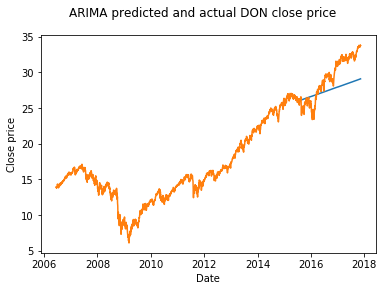

In [37]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import train_test_split
import math
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

def arima_model(df, p, d, q):
    test_index = math.ceil(.8 * len(df))
    train, test = df.iloc[:test_index], df.iloc[test_index+1:]
    num_steps = len(test)
    model = ARIMA(train, order=(q,d,p))
    model_fit = model.fit(disp=0, transparams= False)
    predicted_vals = model_fit.forecast(steps = num_steps)[0].flatten()
    mse = mean_squared_error(test, predicted_vals)
    df_predicted = pd.DataFrame(predicted_vals, index= df.index[test_index+1:])
    model_dict = {'df_predicted': df_predicted, 'mse': mse, 'model_fit': model_fit, 'model': model}
    return model_dict
    

    
don_close_arima = arima_model(don_close_all,ar_prm_don_all_days, 1, ma_prm_don_all_days)

don_predicted_all_df = don_close_arima['df_predicted']
plt.plot(don_predicted_all_df)
plt.plot(don_close_all)
plt.ylabel('Close price')
plt.xlabel('Date')
plt.suptitle('ARIMA predicted and actual DON close price')


Text(0.5, 1.0, '120 Day ARIMA predicted and actual DON close price 2011-12-07 00:00:00 to 2012-04-05 00:00:00')

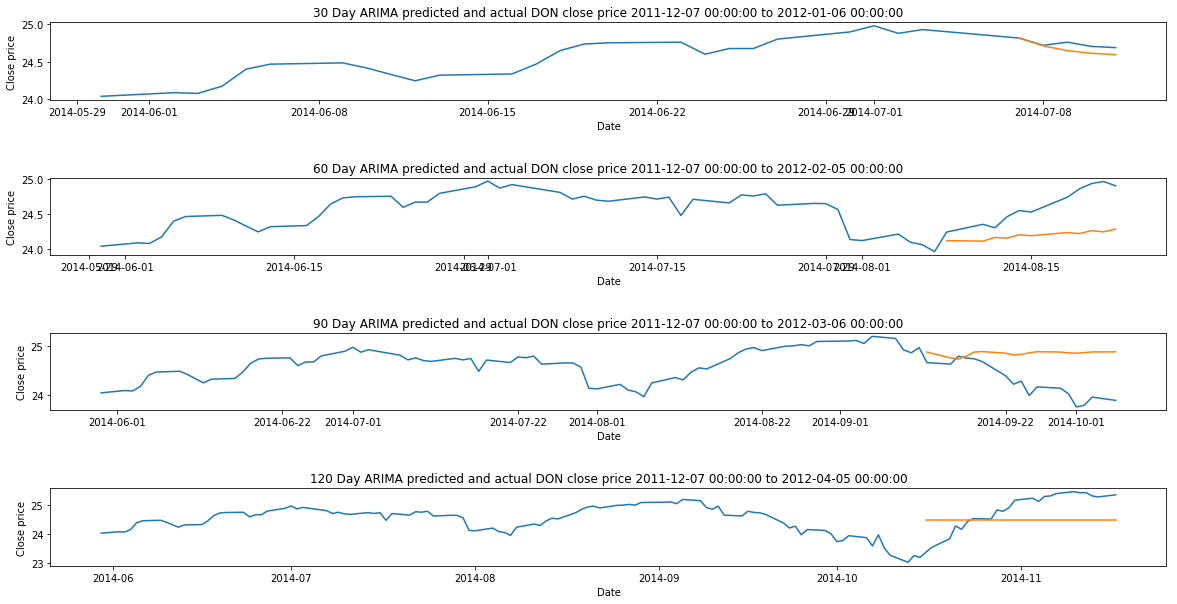

In [45]:
d_prm_don_dict = {30 : 0, 60: 0, 90: 0, 120: 0}
   
def arima_model_dict(dict_df, ar_dict, d_dict, ma_dict):
    results_dict = {}
    for i in dict_df:
        results_dict[i] = arima_model(dict_df[i], ar_dict[i], d_dict[i], ma_dict[i])
    return results_dict
    
don_close_arima_dict = arima_model_dict(don_close_dict, ar_prm_don_dict, d_prm_don_dict, ma_prm_don_dict)

fig, axes = plt.subplots(4, gridspec_kw={'hspace': 1, 'wspace': 1}, figsize=(20,10))
for ax in axes.flat:
    ax.set(xlabel='Date', ylabel='Close price')
     
days_30_arima, days_60_arima = don_close_arima_dict[30]['df_predicted'], don_close_arima_dict[60]['df_predicted']
days_90_arima, days_120_arima = don_close_arima_dict[90]['df_predicted'], don_close_arima_dict[120]['df_predicted']
    
axes[0].plot(don_close_dict[30])
axes[0].plot(days_30_arima)
axes[0].set_title('30 Day ARIMA predicted and actual DON close price '+ str(start_date) + ' to ' + str(end_dates_lst[0]))


axes[1].plot(don_close_dict[60])
axes[1].plot(days_60_arima)
axes[1].set_title('60 Day ARIMA predicted and actual DON close price '+ str(start_date) + ' to ' + str(end_dates_lst[1]))

axes[2].plot(don_close_dict[90])
axes[2].plot(days_90_arima)
axes[2].set_title('90 Day ARIMA predicted and actual DON close price '+ str(start_date) + ' to ' + str(end_dates_lst[2]))

axes[3].plot(don_close_dict[120])
axes[3].plot(days_120_arima)
axes[3].set_title('120 Day ARIMA predicted and actual DON close price '+ str(start_date) + ' to ' + str(end_dates_lst[3]))

Text(0.5, 0.98, 'SVR predicted and actual DON close price')

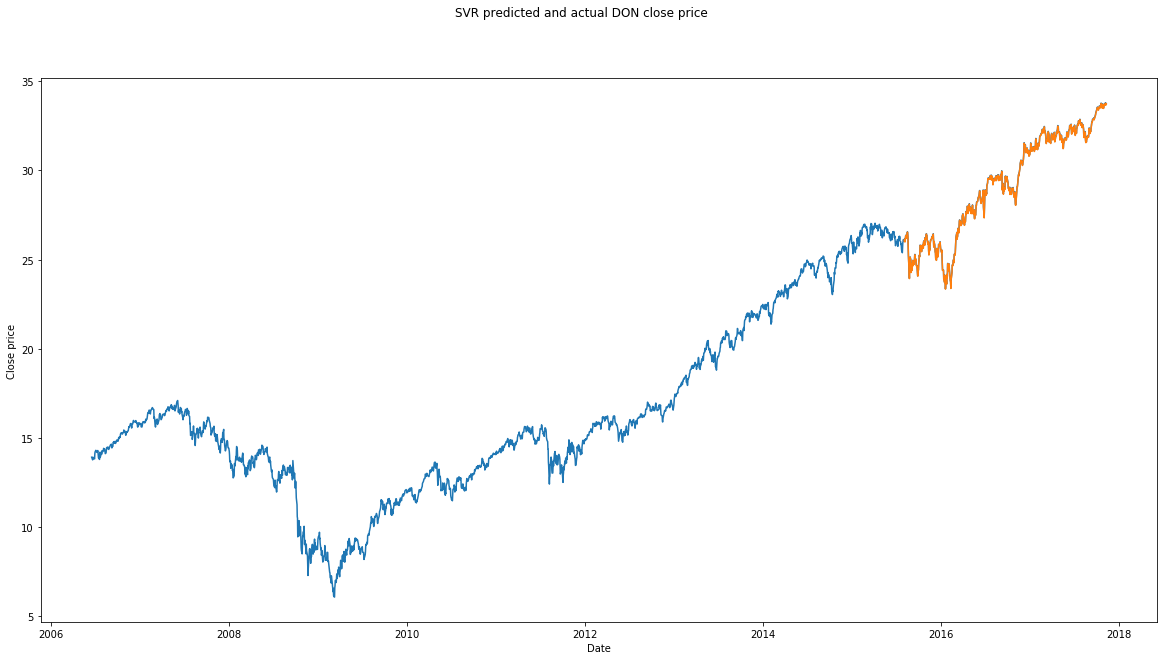

In [26]:
#SVM prediction
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

def create_df_close_change(df, change_days):
    data = df.values
    df_new = pd.DataFrame(data, df.index, columns = ['close'])
    df_new['change'] = df_new['close'].shift(change_days)
    return df_new.fillna(0)
    

don_all_price_change = create_df_close_change(don_close_all, 1)
def svr_predict(df):
    X_train, X_test, y_train, y_test = train_test_split(df['close'], df['change'], test_size=.2, shuffle=False)
    model = SVR(kernel = 'linear')
    model_fit = model.fit(X_train.ravel().reshape(-1,1), y_train)
    predicted_vals = model_fit.predict(X_test.ravel().reshape(-1,1))
    df_predicted = pd.DataFrame(predicted_vals, index= y_test.index, columns = ['predicted price'])
    mse = mean_squared_error(X_test, predicted_vals)
    model_dict = {'df_predicted': df_predicted, 'mse': mse, 'model_fit': model_fit, 'model': model}
    return model_dict

don_all_svr = svr_predict(don_all_price_change)
plt.figure(figsize=(20,10))
plt.plot(don_close_all)
plt.plot(don_all_svr['df_predicted'])
plt.ylabel('Close price')
plt.xlabel('Date')
plt.suptitle('SVR predicted and actual DON close price')



Text(0.5, 1.0, '120 Day SVR predicted and actual DON close price 2011-12-07 00:00:00 to 2012-04-05 00:00:00')

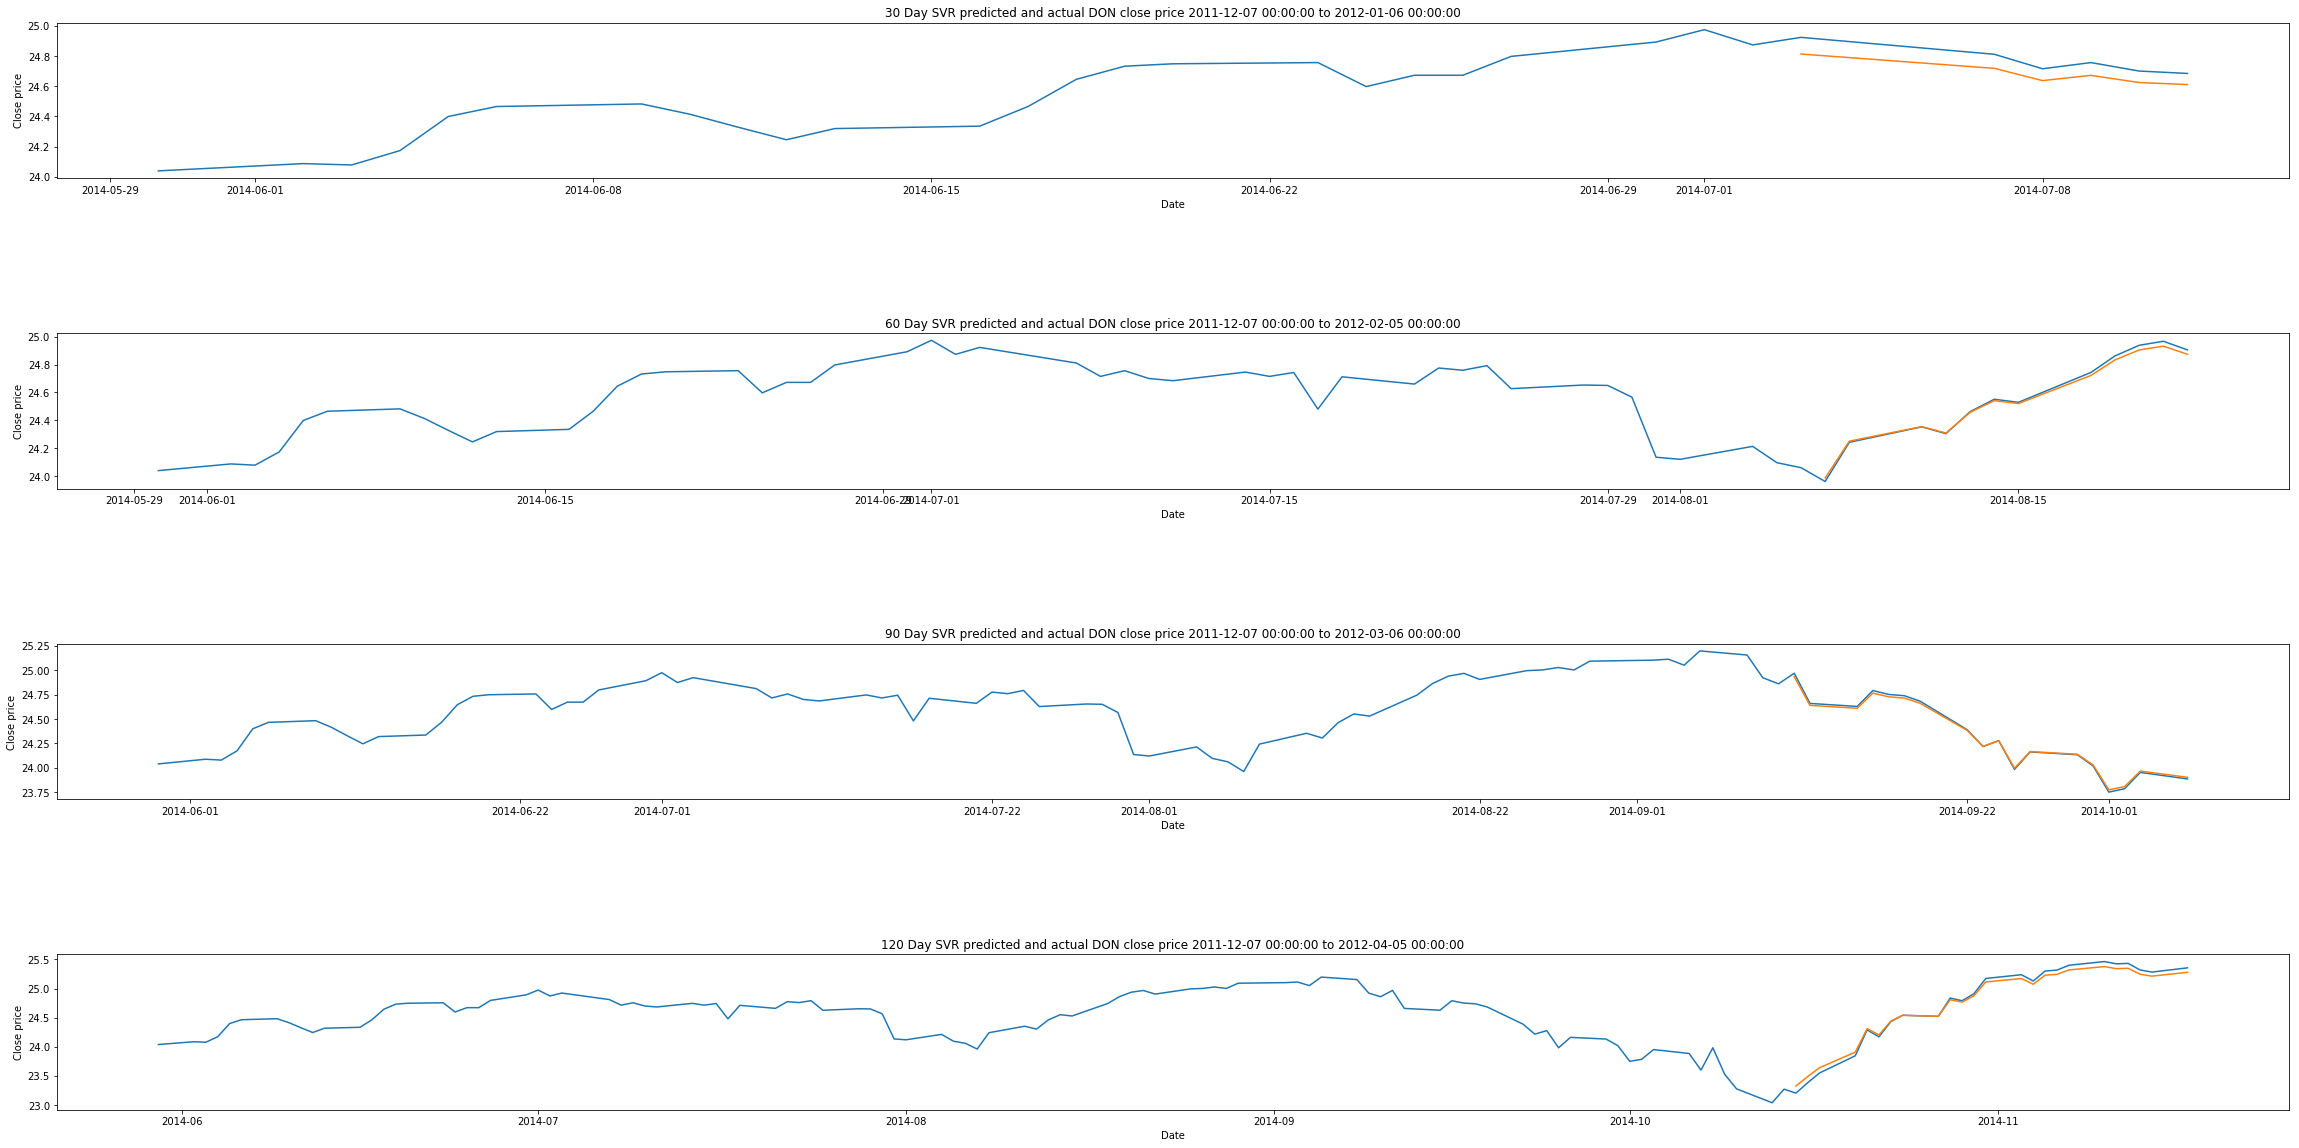

In [27]:
def create_df_close_change_dict(df_dict, change_days):
    new_dict = {}
    for i in df_dict:
        new_dict[i] = create_df_close_change(df_dict[i], change_days)
    return new_dict
        


def svr_predict_dict(df_dict):
    new_dict = {}
    for i in df_dict:
        new_dict[i] = svm_predict(df_dict[i])
    return new_dict

close_change_dict = create_df_close_change_dict(don_close_dict, 1)

svr_dict = svr_predict_dict(close_change_dict)

fig, axes = plt.subplots(4, gridspec_kw={'hspace': 1, 'wspace': 1}, figsize=(40,20))
for ax in axes.flat:
    ax.set(xlabel='Date', ylabel='Close price')

days_30_svr, days_60_svr = svr_dict[30]['df_predicted'], svr_dict[60]['df_predicted']
days_90_svr, days_120_svr = svr_dict[90]['df_predicted'], svr_dict[120]['df_predicted']
    
axes[0].plot(don_close_dict[30])
axes[0].plot(days_30_svr)
axes[0].set_title('30 Day SVR predicted and actual DON close price '+ str(start_date) + ' to ' + str(end_dates_lst[0]))


axes[1].plot(don_close_dict[60])
axes[1].plot(days_60_svr)
axes[1].set_title('60 Day SVR predicted and actual DON close price '+ str(start_date) + ' to ' + str(end_dates_lst[1]))

axes[2].plot(don_close_dict[90])
axes[2].plot(days_90_svr)
axes[2].set_title('90 Day SVR predicted and actual DON close price '+ str(start_date) + ' to ' + str(end_dates_lst[2]))


axes[3].plot(don_close_dict[120])
axes[3].plot(days_120_svr)
axes[3].set_title('120 Day SVR predicted and actual DON close price '+ str(start_date) + ' to ' + str(end_dates_lst[3]))    